In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

In [4]:
building_gdf = gpd.read_file("C:/Users/Melis/Desktop/data/yapi/yapi.shp")

In [5]:
original_crs = building_gdf.crs

In [6]:
target_crs = CRS.from_epsg(32635)  # Change the EPSG code to your desired CRS
building_gdf = building_gdf.to_crs(target_crs)

# Create a new GeoDataFrame with center points of the buildings
building_gdf['center'] = building_gdf['geometry'].centroid
points_gdf = gpd.GeoDataFrame(geometry=building_gdf['geometry'].centroid, crs=building_gdf.crs)

# Now, you can add meters to the buffer distance
buffer_distance_meters = 20  # Adjust this value as needed

# Create a buffer around the center points
building_gdf['buffer'] = building_gdf['center'].buffer(buffer_distance_meters)

mean_distances = {}

for index, building in building_gdf.iterrows():
    center_point = building['center']
    buffer = building['buffer']
    
    # Replace 'points_gdf' with the actual name of your points GeoDataFrame
    points_within_buffer = points_gdf[points_gdf['geometry'].within(buffer)]
    
    # Compute distances to points within the buffer
    distances = points_within_buffer.distance(center_point)
    
    # Exclude distances equal to zero
    distances = distances[distances > 0]
    
    if len(distances) > 0:
        # Calculate the mean distance
        mean_distance = distances.mean()
    else:
        # If there are no non-zero distances, set mean_distance to NaN or any other appropriate value
        mean_distance = float('nan')
    
    # Store the mean distance in the dictionary with the building's ID as the key
    building_id = building['OBJECTID_1']  # Replace 'OBJECTID_1' with your building ID column
    mean_distances[building_id] = mean_distance

# Add a new column 'mean_distance' to the building_gdf
building_gdf['mean_distance'] = building_gdf['OBJECTID_1'].map(mean_distances)

D:\ANACONDO_3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


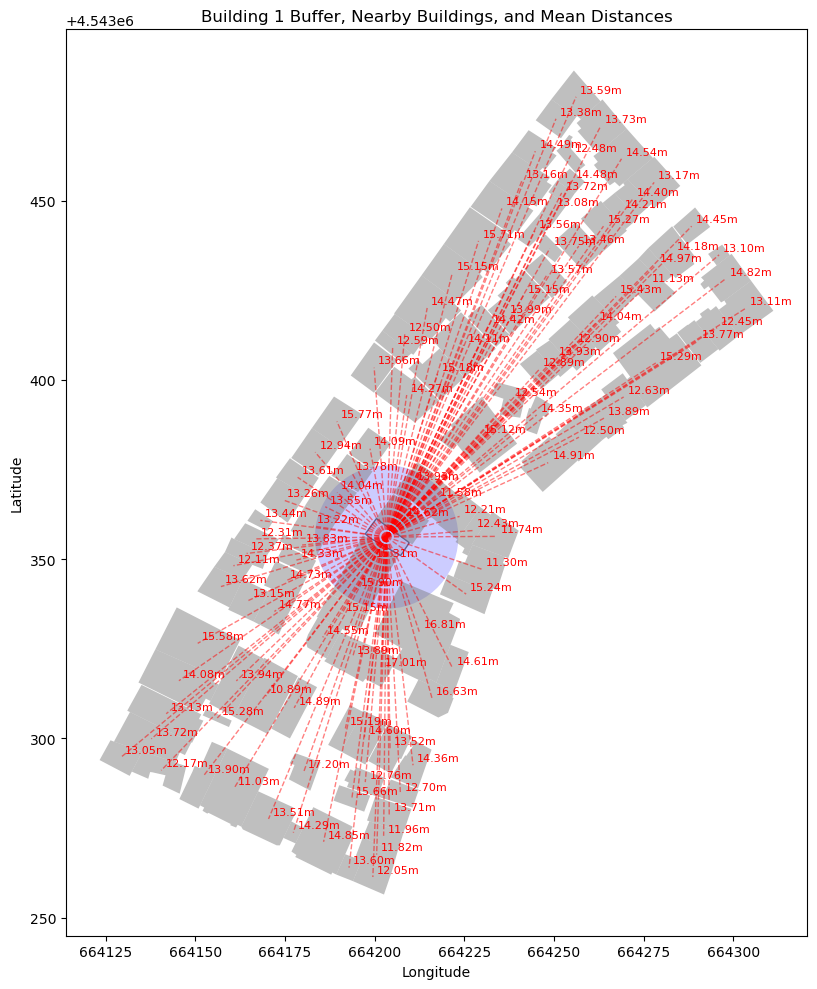

In [12]:
#Visualizing the distances of a building to other structures

import matplotlib.pyplot as plt
import geopandas as gpd

# Create a base to visualize the center and buffer of the selected building
fig, ax = plt.subplots(figsize=(10, 10))

# Visualize the selected building and its buffer
selected_building.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
selected_building['buffer'].plot(ax=ax, color='blue', alpha=0.2)

# Visualize the centers of other buildings in the area
building_gdf[building_gdf['OBJECTID_1'] != selected_building_id].plot(ax=ax, color='gray', alpha=0.5)

# Visualize the distances between the center of each building and the center of the selected building
for index, row in building_gdf.iterrows():
    if row['OBJECTID_1'] != selected_building_id:  # Skip the selected building
        center_point = row['center']
        distance = row['mean_distance']
        
        # Draw the distance line
        ax.plot([selected_building['center'].x, center_point.x], [selected_building['center'].y, center_point.y],
                color='red', linestyle='--', linewidth=1, alpha=0.5)
        
        # Write the distance
        ax.annotate(text=f'{distance:.2f}m', xy=(center_point.x, center_point.y), xytext=(3, 3),
                    textcoords="offset points", fontsize=8, color='red')

# Adjust axes and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Building {selected_building_id} Buffer, Nearby Buildings, and Mean Distances')

# Show image
plt.tight_layout()
plt.show()


D:\ANACONDO_3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


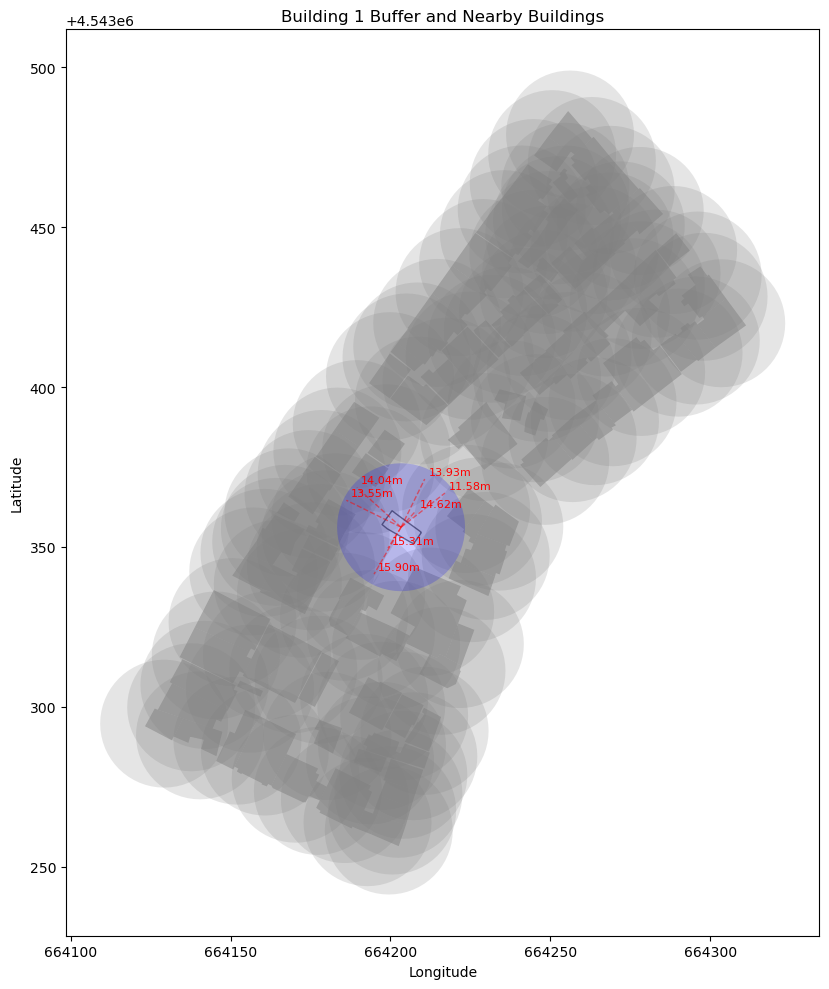

In [15]:
# Alternative visualization-1

import matplotlib.pyplot as plt
import geopandas as gpd

# Create a base to visualize the center and buffer of the selected building
fig, ax = plt.subplots(figsize=(10, 10))

# Visualize the selected building and its buffer
selected_building.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
selected_building['buffer'].plot(ax=ax, color='blue', alpha=0.2)

# Visualize the distances between the center of each building and the center of the selected building
for index, row in building_gdf.iterrows():
    if row['OBJECTID_1'] != selected_building_id:  # Skip the selected building
        center_point = row['center']
        if selected_building['buffer'].contains(center_point).any():  #Check if it is in the center buffer
            distance = row['mean_distance']
            
            # Draw the distance line
            ax.plot([selected_building['center'].x, center_point.x], [selected_building['center'].y, center_point.y],
                    color='red', linestyle='--', linewidth=1, alpha=0.5)
            
            # Write the distance
            ax.annotate(text=f'{distance:.2f}m', xy=(center_point.x, center_point.y), xytext=(3, 3),
                        textcoords="offset points", fontsize=8, color='red')

# Visualize the centers and buffers of other structures that fall within the other zone
other_buildings = building_gdf[~building_gdf['buffer'].contains(selected_building['center'].iloc[0])]
other_buildings.plot(ax=ax, color='gray', alpha=0.5, zorder=0)
other_buildings['buffer'].plot(ax=ax, color='gray', alpha=0.2, zorder=0)

# Adjust axes and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Building {selected_building_id} Buffer and Nearby Buildings')

# Show image
plt.tight_layout()
plt.show()


D:\ANACONDO_3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


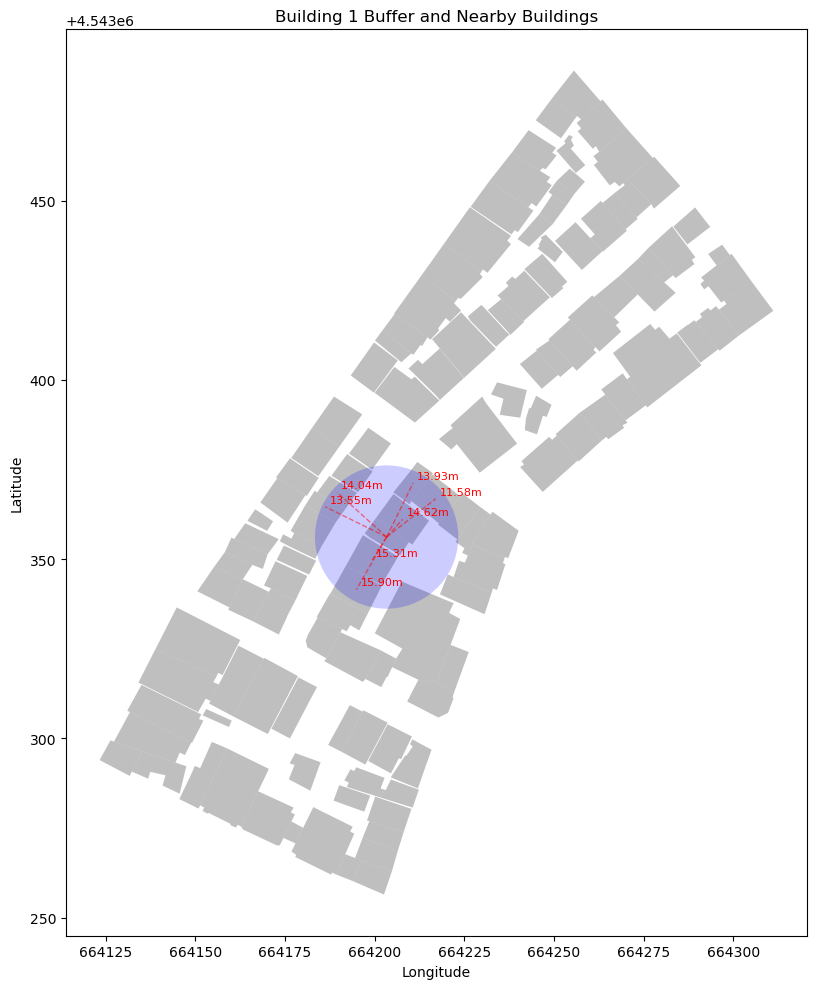

In [18]:
# Alternative visualization-2

import matplotlib.pyplot as plt
import geopandas as gpd

# Create a base to visualize the center and buffer of the selected building
fig, ax = plt.subplots(figsize=(10, 10))

# Visualize all structures in the same color
building_gdf.plot(ax=ax, color='gray', alpha=0.5)

# Visualize the buffer of the selected building
selected_building['buffer'].plot(ax=ax, color='blue', alpha=0.2)

# Visualize the centers of other buildings inside the Buffer
for index, row in building_gdf.iterrows():
    if row['OBJECTID_1'] != selected_building_id:  # Skip the selected building
        center_point = row['center']
        if selected_building['buffer'].contains(center_point).any():  # Check if it is in the center buffer
            distance = row['mean_distance']
            
            # Draw the distance line
            ax.plot([selected_building['center'].x, center_point.x], [selected_building['center'].y, center_point.y],
                    color='red', linestyle='--', linewidth=1, alpha=0.5)
            
            # Write the distance
            ax.annotate(text=f'{distance:.2f}m', xy=(center_point.x, center_point.y), xytext=(3, 3),
                        textcoords="offset points", fontsize=8, color='red')

# Adjust axes and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Building {selected_building_id} Buffer and Nearby Buildings')

# Show image
plt.tight_layout()
plt.show()


D:\ANACONDO_3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


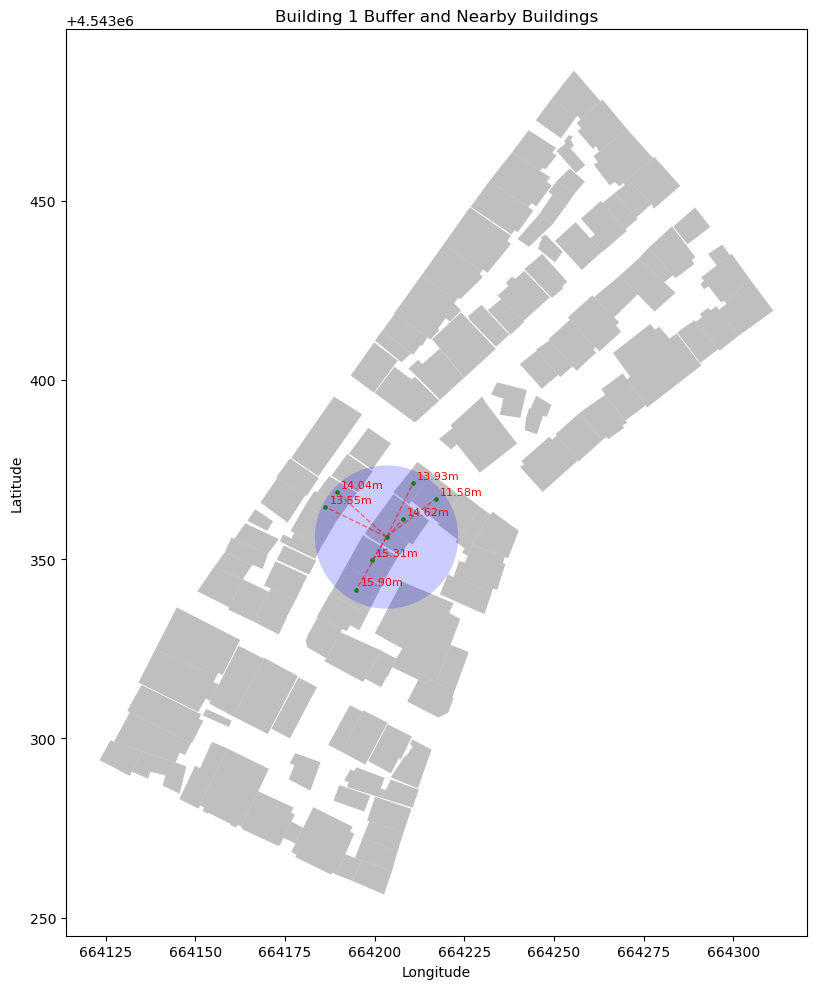

In [22]:
# Alternative visualization-3

import matplotlib.pyplot as plt
import geopandas as gpd

# Create a base to visualize the center and buffer of the selected building
fig, ax = plt.subplots(figsize=(10, 10))

# Visualize all structures in the same color
building_gdf.plot(ax=ax, color='gray', alpha=0.5)

# Visualize the buffer of the selected building
selected_building['buffer'].plot(ax=ax, color='blue', alpha=0.2)

# Visualize hubs and buffers of other buildings inside the Buffer
for index, row in building_gdf.iterrows():
    if row['OBJECTID_1'] != selected_building_id:  # Skip the selected building
        center_point = row['center']
        if selected_building['buffer'].contains(center_point).any():  # Check if it is in the center buffer
            distance = row['mean_distance']
            
            # Draw the distance line
            ax.plot([selected_building['center'].x, center_point.x], [selected_building['center'].y, center_point.y],
                    color='red', linestyle='--', linewidth=1, alpha=0.5)
            
            # Write the distance
            ax.annotate(text=f'{distance:.2f}m', xy=(center_point.x, center_point.y), xytext=(3, 3),
                        textcoords="offset points", fontsize=8, color='red')

# Visualize the midpoints of other buildings inside the Buffer as dots
points_gdf = gpd.GeoDataFrame(geometry=building_gdf[building_gdf['buffer'].contains(selected_building['center'].iloc[0])]['center'], crs=building_gdf.crs)
points_gdf.plot(ax=ax, color='green', markersize=5, zorder=2)

# Adjust axes and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Building {selected_building_id} Buffer and Nearby Buildings')

# Show image
plt.tight_layout()
plt.show()


In [7]:
building_gdf.head(3)

,OBJECTID_1,TARGET_FID,OBJECTID,ILCEKN,MAHALLEKN,KIMLIKNO,BINAKODU,AD,TIP,DURUM,...,Shape_Le_1,Shape_Area,MESKEN,YAPI_ADASI,ADA_ID,uID,geometry,center,buffer,mean_distance
0,1,139,3421,1327,99144,276612850,276612850,None,1,1,...,32.629665,57.048525,1.0,311080,311080,1,"POLYGON ((664209.502 4543354.685, 664207.082 4...",POINT (664203.311 4543356.169),"POLYGON ((664223.311 4543356.169, 664223.215 4...",14.728960
1,2,273,7498,1327,99144,261603435,261603435,None,1,1,...,44.066645,94.332612,1.0,310967,310967,2,"POLYGON ((664176.340 4543299.990, 664171.179 4...",POINT (664177.529 4543308.512),"POLYGON ((664197.529 4543308.512, 664197.433 4...",14.890446
2,3,274,7499,1327,99144,273043505,273043505,Özlem Apartmanı,1,1,...,36.007051,80.824016,1.0,311399,311399,3,"POLYGON ((664180.676 4543367.843, 664175.682 4...",POINT (664174.366 4543366.536),"POLYGON ((664194.366 4543366.536, 664194.270 4...",13.260417


In [7]:
buffer_avr= building_gdf.copy()

In [8]:
# Create any excel file
buffer_avr.to_excel('buffer_avr.xlsx', index=False)

In [10]:
import pandas as pd

# Replace 'buffer_avr.xlsx' with the path to your Excel file.
file_path = 'buffer_avr.xlsx'

# Read the Excel file into a Pandas DataFrame.
df = pd.read_excel(file_path)

# Select the 'distance' and 'IBB_KIMLIK' columns.
selected_columns = df[['mean_distance', 'IBB_KIMLIK']]

# Specify the path and name for the new Excel file where you want to save the selected columns.
output_file_path = 'selected_columns_output.xlsx'

# Save the selected columns to a new Excel file.
selected_columns.to_excel(output_file_path, index=False)
